# Import libraries

In [79]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from mplcursors import cursor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neural_network import MLPClassifier
%matplotlib inline


# Data Preprocessing

In [56]:
# Read CSV input file
df = pd.read_csv('C:/Users/Atique/Documents/Fraud_Case/Fraud.csv')

In [57]:
# Fixed columns by removing "'" from data
column_fix = ['customer','age','gender','zipcodeOri','merchant','zipMerchant','category']
df[column_fix] = df[column_fix].applymap(lambda x: x.strip("'"))

C:\Users\Atique\AppData\Local\Temp\ipykernel_18132\3262960976.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[column_fix] = df[column_fix].applymap(lambda x: x.strip("'"))


In [58]:
# Removed columns with 1 constant value and high number of categorical values like merchant (based on Initial analysis)
df = df.drop(['zipcodeOri','zipMerchant','merchant'],axis=1)

In [59]:
# Check for missing or null values
df.isnull().sum() # NO missing values

step        0
customer    0
age         0
gender      0
category    0
amount      0
fraud       0
dtype: int64

In [60]:
# Check unique count
df.nunique()

step          180
customer     4112
age             8
gender          4
category       15
amount      23767
fraud           2
dtype: int64

In [61]:
# Creating new features to check if that can help more 
df['Time of day'] = df['step'] % 24
df['AvgTransactionAmt'] = df.groupby('customer')['amount'].transform('mean')
df['HighValueRatio'] = np.where(df['amount'] > df['AvgTransactionAmt'] * 2, 1, 0)  # Ratio of high-value transactions (can adjust multiplier)

In [62]:
# Drop unique id 'Customer'
df = df.drop('customer',axis=1)

In [63]:
# One Hot Encoding Categorical Data (having small unique categories)
categorical_features = ['age', 'gender']
encoder = OneHotEncoder(drop='first', sparse_output=False)

In [64]:
# Transform the encoded features
encoded_features = encoder.fit_transform(df[categorical_features])

In [65]:
# Combine encoded features with original data
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))
df = df.drop(categorical_features, axis=1)
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [66]:
# Encode categorical variables (using Label_encoder if unique categories are more than 10)
label_encoder = LabelEncoder()
df['category'] = label_encoder.fit_transform(df['category'])

In [67]:
scaler = StandardScaler()
numerical_features = ['category', 'amount', 'AvgTransactionAmt', 'HighValueRatio', 'Time of day']  # Add other numerical features as needed
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   step               594643 non-null  int64  
 1   category           594643 non-null  float64
 2   amount             594643 non-null  float64
 3   fraud              594643 non-null  int64  
 4   Time of day        594643 non-null  float64
 5   AvgTransactionAmt  594643 non-null  float64
 6   HighValueRatio     594643 non-null  float64
 7   age_1              594643 non-null  float64
 8   age_2              594643 non-null  float64
 9   age_3              594643 non-null  float64
 10  age_4              594643 non-null  float64
 11  age_5              594643 non-null  float64
 12  age_6              594643 non-null  float64
 13  age_U              594643 non-null  float64
 14  gender_F           594643 non-null  float64
 15  gender_M           594643 non-null  float64
 16  ge

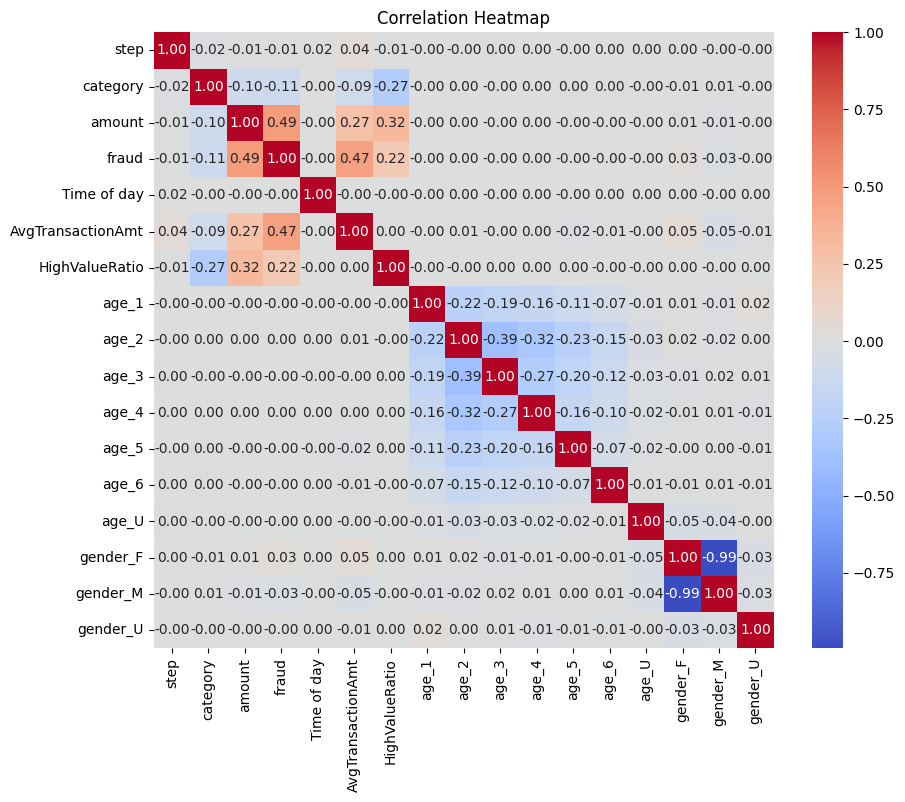

In [69]:
# Example: Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [70]:
correlation_threshold = 0.01
less_useful_columns = df.columns[df.corr()['fraud'].abs() < correlation_threshold]
less_useful_columns
df = df.drop(less_useful_columns, axis=1)

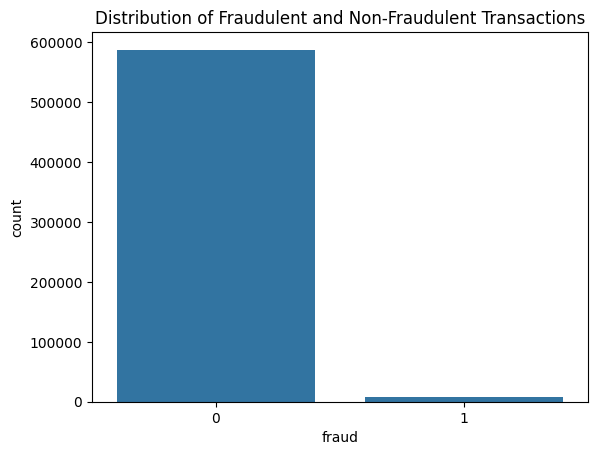

In [71]:
# Distribution of the target variable "Fraud"
sns.countplot(x='fraud', data=df)
plt.title('Distribution of Fraudulent and Non-Fraudulent Transactions')

plt.show()

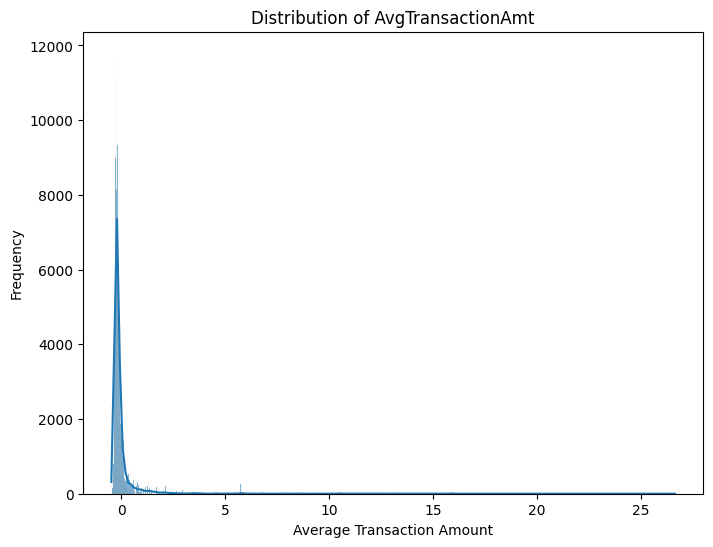

In [72]:
# Plot distribution of 'AvgTransactionAmt'
plt.figure(figsize=(8, 6))
sns.histplot(df['AvgTransactionAmt'], kde=True)
plt.title('Distribution of AvgTransactionAmt')
plt.xlabel('Average Transaction Amount')
plt.ylabel('Frequency')
plt.show()

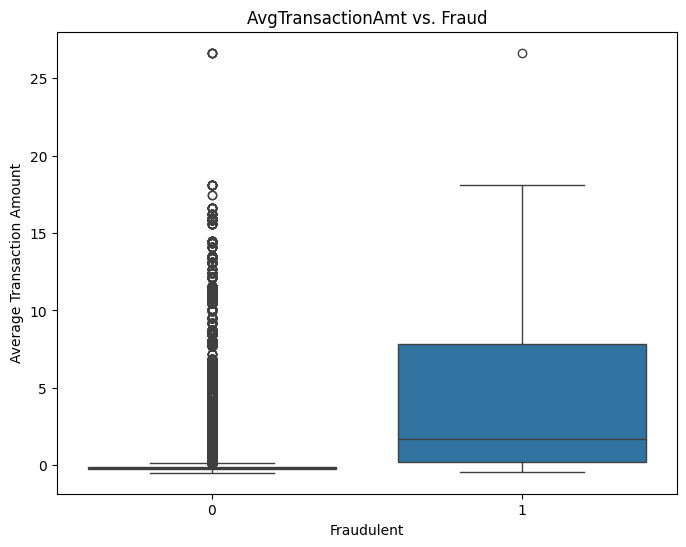

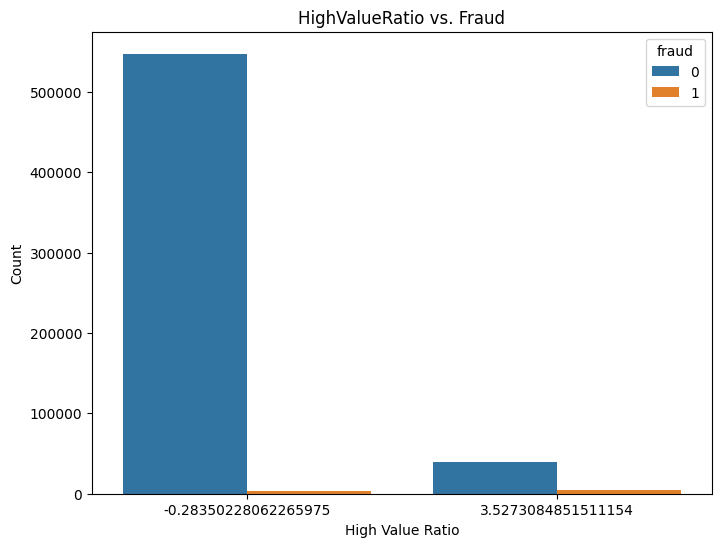

In [74]:
# Relationship between 'AvgTransactionAmt' and 'Fraud'
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='fraud', y='AvgTransactionAmt')
plt.title('AvgTransactionAmt vs. Fraud')
plt.xlabel('Fraudulent')
plt.ylabel('Average Transaction Amount')
plt.show()

# Relationship between 'HighValueRatio' and 'Fraud'
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='HighValueRatio', hue='fraud')
plt.title('HighValueRatio vs. Fraud')
plt.xlabel('High Value Ratio')
plt.ylabel('Count')
plt.show()

In [75]:
# Split dataset into features and target variable
X = df.drop('fraud', axis=1)
y = df['fraud']


# Handling Imbalance Data

In [80]:
### Apply Sampling Technique to handle Imbalance Data 
### NOTE: Data Size is around 0.6 Millions. If we do oversampling, size is going to be around 1.1 Millions. This really take heavy computational time
###       Opting for Oversampling only if CPU  is good enough or if GPU can be used as CUDA. This may take time to run.
###       As of now for assignment purpose, undersampling will be used.

### Oversampling using SMOTE

#smote = SMOTE()
#X_resampled,y_resampled = smote.fit_resample(X,y)
#X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### Undersampling using RandomUnderSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the undersampling strategy
undersampler = RandomUnderSampler(random_state=42)

# Undersample the majority class in the training set
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)


# Model Selection, Fine-Tuning, Training & Evaluation

In [90]:
# Define parameter grids for each model
rf_param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]}
gb_param_grid = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
lr_param_grid = {'C': [0.1, 1, 10], 'max_iter': [100, 200, 300]}
nn_param_grid = {'hidden_layer_sizes': [(50,), (100,), (200,)], 'alpha': [0.0001, 0.001, 0.01]}


In [91]:
# Model 1: Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3)
rf_grid_search.fit(X_resampled, y_resampled)
rf_best_model = rf_grid_search.best_estimator_

# Model 1 Evaluation after Fine-Tuning
print("Random Forest Classification Report (after Fine-Tuning):")
print(classification_report(y_test, rf_best_model.predict(X_test)))

Random Forest Classification Report (after Fine-Tuning):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    117512
           1       0.24      0.98      0.39      1417

    accuracy                           0.96    118929
   macro avg       0.62      0.97      0.68    118929
weighted avg       0.99      0.96      0.97    118929



In [82]:
# Model 2: Gradient Boosting
gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=3)
gb_grid_search.fit(X_resampled, y_resampled)
gb_best_model = gb_grid_search.best_estimator_

# Model 2 Evaluation after Fine-Tuning
print("Gradient Boosting Classification Report (after Fine-Tuning):")
print(classification_report(y_test, gb_best_model.predict(X_test)))

Gradient Boosting Classification Report (after Fine-Tuning):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    117512
           1       0.25      0.98      0.40      1417

    accuracy                           0.97    118929
   macro avg       0.63      0.97      0.69    118929
weighted avg       0.99      0.97      0.98    118929



In [83]:
# Model 3: Logistic Regression

# Scale the features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

lr_grid_search = GridSearchCV(LogisticRegression(random_state=42), lr_param_grid, cv=3)
lr_grid_search.fit(X_resampled_scaled, y_resampled)
lr_best_model = lr_grid_search.best_estimator_

# Model 3 Evaluation after Fine-Tuning
print("Logistic Regression Classification Report (after Fine-Tuning):")
print(classification_report(y_test, lr_best_model.predict(X_test_scaled)))

Logistic Regression Classification Report (after Fine-Tuning):
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    117512
           1       0.25      0.93      0.39      1417

    accuracy                           0.97    118929
   macro avg       0.62      0.95      0.69    118929
weighted avg       0.99      0.97      0.98    118929



In [84]:
# Model 4: Neural Network
nn_grid_search = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), nn_param_grid, cv=3)
nn_grid_search.fit(X_resampled, y_resampled)
nn_best_model = nn_grid_search.best_estimator_

# Model 4 Evaluation after Fine-Tuning
print("Neural Network Classification Report (after Fine-Tuning):")
print(classification_report(y_test, nn_best_model.predict(X_test)))

Neural Network Classification Report (after Fine-Tuning):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    117512
           1       0.24      0.96      0.39      1417

    accuracy                           0.96    118929
   macro avg       0.62      0.96      0.68    118929
weighted avg       0.99      0.96      0.97    118929



In [85]:
# Feature importance for Random Forest
rf_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_best_model.feature_importances_})
rf_feature_importance = rf_feature_importance.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importance:")
print(rf_feature_importance)

Random Forest Feature Importance:
             Feature  Importance
2             amount    0.366028
1           category    0.335999
3  AvgTransactionAmt    0.186977
4     HighValueRatio    0.074965
0               step    0.027679
5           gender_F    0.004923
6           gender_M    0.003430


In [86]:
# Feature importance for Gradient Boosting
gb_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': gb_best_model.feature_importances_})
gb_feature_importance = gb_feature_importance.sort_values(by='Importance', ascending=False)
print("Gradient Boosting Feature Importance:")
print(gb_feature_importance)

Gradient Boosting Feature Importance:
             Feature  Importance
2             amount    0.763607
1           category    0.141093
3  AvgTransactionAmt    0.095299
0               step    0.000000
4     HighValueRatio    0.000000
5           gender_F    0.000000
6           gender_M    0.000000


In [88]:
# Coefficients for Logistic Regression
lr_coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_best_model.coef_[0]})
lr_coefficients = lr_coefficients.sort_values(by='Coefficient', ascending=False)
print("Logistic Regression Coefficients:")
print(lr_coefficients)

Logistic Regression Coefficients:
             Feature  Coefficient
2             amount    14.806775
3  AvgTransactionAmt     4.184764
5           gender_F     1.474491
6           gender_M     1.455600
4     HighValueRatio     0.262218
0               step    -0.070606
1           category    -0.438290


In [89]:
# Neural Network Model Interpretation
# As neural networks don't provide direct feature importances like tree-based models, we can analyze the coefficients of the input layer to understand feature importance.

# Get the coefficients of the input layer
input_layer_coefficients = nn_best_model.coefs_[0]

# Calculate the mean importance score for each feature across all neurons in the input layer
feature_importances_nn = np.mean(np.abs(input_layer_coefficients), axis=1)

# Create a DataFrame to store feature importances
nn_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_nn})
nn_feature_importance = nn_feature_importance.sort_values(by='Importance', ascending=False)

# Print the feature importance for Neural Network
print("Neural Network Feature Importance:")
print(nn_feature_importance)

Neural Network Feature Importance:
             Feature  Importance
3  AvgTransactionAmt    0.160495
1           category    0.153871
2             amount    0.119314
6           gender_M    0.089848
4     HighValueRatio    0.088346
5           gender_F    0.087487
0               step    0.062197
